In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# IMPORTS

In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 21.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
import pandas as pd
from IPython import display
from keras.callbacks import ModelCheckpoint
import tensorflow_addons as tfa
import datetime
import numpy as np

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# FUNCIONES AUXILIARES

In [ ]:
# FUNCION DE MERITO
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

def quadratic_kappa(actuals, preds, N=5):
    """This function calculates the Quadratic Kappa Metric used for Evaluation in the PetFinder competition
    at Kaggle. It returns the Quadratic Weighted Kappa metric score between the actual and the predicted values
    of adoption rating."""
    w = np.zeros((N,N))
    O = confusion_matrix(actuals, preds,labels=[0,1,2,3,4])
    for i in range(len(w)):
        for j in range(len(w)):
            w[i][j] = float(((i-j)**2)/(N-1)**2)

    act_hist=np.zeros(N)
    for item in actuals:
        act_hist[item]+=1

    pred_hist=np.zeros(N)
    for item in preds:
        pred_hist[item]+=1

    E = np.outer(act_hist, pred_hist);
    E = E/E.sum();
    O = O/O.sum();

    num=0
    den=0
    for i in range(len(w)):
        for j in range(len(w)):
            num+=w[i,j]*O[i,j]
            den+=w[i,j]*E[i,j]
    return (1 - (num/den))

In [ ]:
!pip install comet_ml


In [ ]:
# SETEAR COMET
from comet_ml import Experiment
def save_results(cmt_exp, history):
    '''
    Entrada:
        cmt_exp: experimento comet
        cross_val_scores: scikit-learn cross validation results
    '''
    ### Resultados para cada fold ###
    for k in range(len(history['loss'])):
        metrics_step = {
            'Kappa_train':history['cohen_kappa'][k],
            'Acc_train':history['accuracy'][k],
            'Loss_train':history['loss'][k],
            'Khappa_val':history['val_cohen_kappa'][k],
            'Acc_val':history['val_accuracy'][k],
            'Loss_val':history['val_loss'][k],
        }
        cmt_exp.log_metrics(metrics_step,step=k)
    return

def guardar_experimento(model,nombre_modelo,API_KEY='WCc7gVu8o1kRgn1za9Cqhr2WS'):
  exp = Experiment(api_key=API_KEY,
                  project_name='Retinopatia',
                  auto_param_logging=False)
  exp.set_name(nombre_modelo)
  exp.add_tags(['Logs'])
  save_results(exp,model.history.history)
  exp.end()


# LEVANTAR DATA

In [ ]:
def create_gaussian_filter(size, sigma):
    # Crea una matriz de ceros del tamaño especificado
    filter_array = np.zeros((size, size))

    # Calcula el centro del filtro
    center = size // 2

    # Calcula los valores del filtro gaussiano
    for i in range(size):
        for j in range(size):
            filter_array[i, j] = np.exp(-((i - center) ** 2 + (j - center) ** 2) / (2 * sigma ** 2))

    # Normaliza el filtro para que sume 1
    filter_array /= np.sum(filter_array)

    return filter_array

size = 600  # Tamaño del filtro gaussiano
sigma = 20  # Parámetro sigma del filtro gaussiano

# Crea el filtro gaussiano
gaussian_filter = create_gaussian_filter(size, sigma)

# Convierte el filtro en un tensor
gaussian_filter_tensor = tf.convert_to_tensor(gaussian_filter, dtype=tf.float32)

In [ ]:
# Definir la descripción de los campos en el TFRecord

import cv2 , glob

def scaleRadius(img, scale = 300):
  x = tf.math.reduce_sum(tf.cast(img[int(tf.shape(img)[0]/2), :, :], tf.float32), axis=1)
  r = tf.math.reduce_sum(tf.cast((x>tf.math.reduce_mean(x)/10), tf.float32))/2
  if (r<50):
    r=tf.constant(50.)
  s = scale * 1.0/ r
  shape = tf.cast(tf.shape(img),tf.float32)
  img_pre = tf.image.resize(img, (shape[0]*s, shape[1]*s))
  if (s<tf.constant(1.0)):
    img_pre = tf.image.pad_to_bounding_box(img_pre,( tf.constant(640) - tf.shape(img_pre)[0])//2, tf.constant(0) ,tf.constant(640), tf.shape(img_pre)[1])
  img_pre = img_pre[tf.shape(img_pre)[0]//2 - tf.constant(scale):tf.shape(img_pre)[0]//2 + tf.constant(scale), tf.shape(img_pre)[1]//2 - tf.constant(scale):tf.shape(img_pre)[1]//2 + tf.constant(scale), :]
  img_pre = tf.cast(img_pre,tf.uint8)
  return img_pre

def addWeighted(img, alpha=4, beta=-4, gamma=128, scale=300, filter_tensor=gaussian_filter_tensor):

    img = tf.cast(img, tf.float32)
    sigma=scale/30

    filtered_image = apply_gaussian_filter(img, filter_tensor)

    weighted_sum = tf.add(tf.multiply(img, alpha), tf.multiply(filtered_image, beta))
    weighted_sum = tf.add(weighted_sum, gamma)

    return tf.cast(weighted_sum, tf.uint8)

def apply_gaussian_filter(img, filter_tensor):
    img_red = img[:,:,0]
    img_blue = img[:,:,2]
    img_green = img[:,:,1]


    image_complex_red = tf.cast(img_red, dtype=tf.complex64)
    image_complex_blue = tf.cast(img_blue, dtype=tf.complex64)
    image_complex_green = tf.cast(img_green, dtype=tf.complex64)

    image_fft_red = tf.signal.fft2d(image_complex_red)
    image_fft_blue = tf.signal.fft2d(image_complex_blue)
    image_fft_green = tf.signal.fft2d(image_complex_green)

    filter_fft = tf.signal.fft2d(tf.cast(gaussian_filter_tensor, dtype=tf.complex64))


    filtered_red_fft = tf.multiply(image_fft_red, filter_fft)
    filtered_blue_fft = tf.multiply(image_fft_blue, filter_fft)
    filtered_green_fft = tf.multiply(image_fft_green, filter_fft)

    filtered_red_fft = tf.signal.ifftshift(tf.math.abs(tf.signal.ifft2d(filtered_red_fft)))
    filtered_blue_fft = tf.signal.ifftshift(tf.math.abs(tf.signal.ifft2d(filtered_blue_fft)))
    filtered_green_fft = tf.signal.ifftshift(tf.math.abs(tf.signal.ifft2d(filtered_green_fft)))

    filtered_image = tf.cast(tf.stack([filtered_red_fft,filtered_green_fft,filtered_blue_fft],axis=-1),tf.float32)
    return filtered_image



# Crear el dataset a partir del TFRecord
import os
directory = '/content/drive/MyDrive/Proyecto-2/retinopatia_entrenamiento/tf_records'

feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'image_name': tf.io.FixedLenFeature([], tf.string),
    'eye': tf.io.FixedLenFeature([], tf.int64),
    'level_cat': tf.io.FixedLenFeature([], tf.int64)
}

# Función para parsear los datos del TFRecord
def parse_tfrecord_fn(example):
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_jpeg(example['image'], channels=3)  # Decodificar imagen (asumiendo formato JPEG)
    image_name = example['image_name']
    eye = example['eye']
    level_cat = example['level_cat']
    return image, image_name, eye, level_cat

  # Definir la descripción de las características del TFRecord
feature_description_preprocessed = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64)
}

    # Función para parsear los datos del TFRecord
def parse_tfrecord_fn_preprocessed(example):
    example = tf.io.parse_single_example(example, feature_description_preprocessed)
    image = tf.io.decode_jpeg(example['image'], channels=3)  # Decodificar imagen (asumiendo formato JPEG)
    label = example['label']
    return image, label

def preprocess(img, scale = 300):
  img = tf.cast(tf.image.resize_with_pad(img,640,1024),tf.uint8)
  img_pre = scaleRadius(img)
  # img_gray = addWeighted(img_pre)
  return img_pre


def onehot(y):
  return tf.one_hot(y, 5)


for idx,filename in enumerate(os.listdir(directory)):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        dataset_i = tf.data.TFRecordDataset(f)
        dataset_i = dataset_i.map(parse_tfrecord_fn)
        X = dataset_i.map(lambda image, image_name, eye, level_cat: image).map(preprocess)
        y = dataset_i.map(lambda image, image_name, eye, level_cat: level_cat)#.map(onehot)
        dataset_final = tf.data.Dataset.zip((X,y))
        if idx ==0:
          dataset = dataset_final
        else:
          dataset = dataset.concatenate(dataset_final)


dataset = dataset.batch(32)
# ds_train = dataset.take(900)
# ds_val = dataset.skip(900)

In [ ]:
output_directory = '/content/drive/MyDrive/TAA/Proyecto-2/retinopatia_entrenamiento/tf_records_preprocessed'

# Función para convertir los datos en un ejemplo de TFRecord
def serialize_example(image, label):
    feature = {
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(image).numpy()])),
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

# Función para guardar el dataset en formato TFRecord
def save_dataset_to_tfrecord(dataset, output_file):
    writer = tf.io.TFRecordWriter(output_file)
    i = 0
    for image, label in dataset:
        print('Imagen ', i, end='\r')
        i += 1
        serialized_example = serialize_example(image, label)
        writer.write(serialized_example)
    writer.close()

# Guardar el dataset en formato TFRecord
save_dataset_to_tfrecord(dataset, os.path.join(output_directory, 'train_01_pre.tfrecord'))

In [ ]:
directory_pre = '/content/drive/MyDrive/TAA/Proyecto-2/retinopatia_entrenamiento/graham_pre'
for idx,filename in enumerate(os.listdir(directory_pre)):
    f = os.path.join(directory_pre, filename)
    if os.path.isfile(f):
        dataset_i = tf.data.TFRecordDataset(f)
        dataset_i = dataset_i.map(parse_tfrecord_fn_preprocessed)
        X = dataset_i.map(lambda image, level_cat: image)
        y = dataset_i.map(lambda image, level_cat: level_cat)
        dataset_final = tf.data.Dataset.zip((X,y))
        if idx ==0:
          dataset = dataset_final
        else:
          dataset = dataset.concatenate(dataset_final)

dataset = dataset.batch(16)
ds_train = dataset.take(1800)
ds_val = dataset.skip(1800)

tf.Tensor(4, shape=(), dtype=int64)


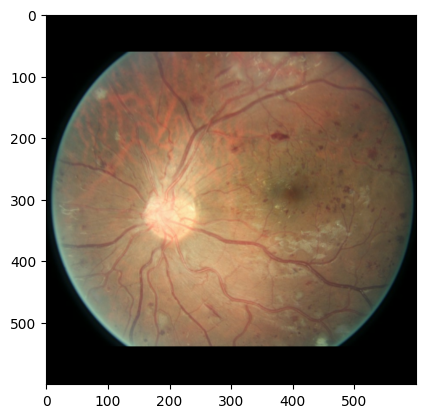

In [ ]:
x,y = next(iter(dataset))
plt.imshow(x[7])
print(y[7])

# PRIMER MODELO


In [ ]:
from functools import partial

tf.random.set_seed(42)  # extra code – ensures reproducibility
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")
model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[1024, 683, 3]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

# TRANSFER LEARNING

In [ ]:
n_classes = 5
tf.random.set_seed(42)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),
    tf.keras.layers.RandomContrast(factor=0.2),
    tf.keras.layers.GaussianNoise(1),
    tf.keras.layers.RandomBrightness(.25)
])

# base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                    #  include_top=False)
base_model = tf.keras.applications.ResNet50(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
modelo = tf.keras.Model(inputs=base_model.input, outputs=output)


model = tf.keras.Sequential([
data_augmentation,
modelo
])


for layer in base_model.layers:
    layer.trainable = False

checkpoint = ModelCheckpoint("/content/drive/MyDrive/Proyecto-2/Modelos/paraSubir-Santi"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), monitor='accuracy', verbose=1,
    save_best_only=True, mode='max')
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)
log_dir = "/content/drive/MyDrive/Proyecto-2/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callback_list = [checkpoint,early_stopping, tensorboard_callback]

class_weight = {0: 0.1338,
                1: 1.1577,
                2: 0.8220,
                3: 1.6046,
                4: 1.6956 }

kappa_loss = tfa.losses.WeightedKappaLoss(num_classes=n_classes)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer,
              metrics=["accuracy",tfa.metrics.CohenKappa(num_classes=n_classes,weightage='quadratic',sparse_labels=True)])
history = model.fit(dataset, epochs=2, callbacks = callback_list)

94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/2
   1098/Unknown - 847s 752ms/step - loss: 0.8119 - accuracy: 0.7358 - cohen_kappa: 0.1859
Epoch 1: accuracy improved from -inf to 0.73584, saving model to /content/drive/MyDrive/Proyecto-2/Modelos/paraSubir-Santi20230704-170522


1098/1098 [==============================] - 881s 783ms/step - loss: 0.8119 - accuracy: 0.7358 - cohen_kappa: 0.1859
Epoch 2/2
1098/1098 [==============================] - ETA: 0s - loss: 0.7519 - accuracy: 0.7475 - cohen_kappa: 0.3406
Epoch 2: accuracy improved from 0.73584 to 0.74748, saving model to /content/drive/MyDrive/Proyecto-2/Modelos/paraSubir-Santi20230704-170522


1098/1098 [==============================] - 849s 773ms/step - loss: 0.7519 - accuracy: 0.7475 - cohen_kappa: 0.3406


In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir /content/logs

In [ ]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer_2= tf.keras.optimizers.Adam(learning_rate=0.00002)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer_2,
              metrics=["accuracy",tfa.metrics.CohenKappa(num_classes=n_classes,weightage='quadratic',sparse_labels=True)])
history = model.fit(dataset, epochs=10,callbacks=callback_list)

Epoch 1/10
   1098/Unknown - 1775s 2s/step - loss: 0.6549 - accuracy: 0.7859 - cohen_kappa: 0.5637
Epoch 1: accuracy improved from 0.74748 to 0.78586, saving model to /content/drive/MyDrive/Proyecto-2/Modelos/paraSubir-Santi20230704-170522


1098/1098 [==============================] - 1814s 2s/step - loss: 0.6549 - accuracy: 0.7859 - cohen_kappa: 0.5637
Epoch 2/10
1098/1098 [==============================] - ETA: 0s - loss: 0.5445 - accuracy: 0.8200 - cohen_kappa: 0.6939
Epoch 2: accuracy improved from 0.78586 to 0.82005, saving model to /content/drive/MyDrive/Proyecto-2/Modelos/paraSubir-Santi20230704-170522


1098/1098 [==============================] - 1770s 2s/step - loss: 0.5445 - accuracy: 0.8200 - cohen_kappa: 0.6939
Epoch 3/10
1098/1098 [==============================] - ETA: 0s - loss: 0.5029 - accuracy: 0.8335 - cohen_kappa: 0.7335
Epoch 3: accuracy improved from 0.82005 to 0.83354, saving model to /content/drive/MyDrive/Proyecto-2/Modelos/paraSubir-Santi20230704-170522


1098/1098 [==============================] - 1771s 2s/step - loss: 0.5029 - accuracy: 0.8335 - cohen_kappa: 0.7335
Epoch 4/10
1098/1098 [==============================] - ETA: 0s - loss: 0.4637 - accuracy: 0.8443 - cohen_kappa: 0.7640
Epoch 4: accuracy improved from 0.83354 to 0.84430, saving model to /content/drive/MyDrive/Proyecto-2/Modelos/paraSubir-Santi20230704-170522


1098/1098 [==============================] - 1773s 2s/step - loss: 0.4637 - accuracy: 0.8443 - cohen_kappa: 0.7640
Epoch 5/10
1098/1098 [==============================] - ETA: 0s - loss: 0.4284 - accuracy: 0.8568 - cohen_kappa: 0.7897
Epoch 5: accuracy improved from 0.84430 to 0.85677, saving model to /content/drive/MyDrive/Proyecto-2/Modelos/paraSubir-Santi20230704-170522


1098/1098 [==============================] - 1770s 2s/step - loss: 0.4284 - accuracy: 0.8568 - cohen_kappa: 0.7897
Epoch 6/10
1098/1098 [==============================] - ETA: 0s - loss: 0.3945 - accuracy: 0.8667 - cohen_kappa: 0.8134
Epoch 6: accuracy improved from 0.85677 to 0.86665, saving model to /content/drive/MyDrive/Proyecto-2/Modelos/paraSubir-Santi20230704-170522


1098/1098 [==============================] - 1774s 2s/step - loss: 0.3945 - accuracy: 0.8667 - cohen_kappa: 0.8134
Epoch 7/10
 942/1098 [========================>.....] - ETA: 4:06 - loss: 0.3702 - accuracy: 0.8741 - cohen_kappa: 0.8302

FailedPreconditionError: ignored

In [ ]:
guardar_experimento(model, 'Primero_ResNet')

In [ ]:
loaded_model = tf.keras.models.load_model(
'/content/drive/MyDrive/TAA/Proyecto-2/Modelos/paraSubir20230702-204212')
# loaded_model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
#               metrics=["accuracy",tfa.metrics.CohenKappa(num_classes=5,weightage='quadratic',sparse_labels=True)])
# model.evaluate(ds_train)
# model.evaluate(ds_val)

In [ ]:
loaded_model.get_layer('model').summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

# Matriz de confusion

In [ ]:
labels_train = []
for _, label in ds_train.unbatch():
    labels_train.append(label.numpy())
labels_train = np.array(labels_train)

labels_val = []
for _, label in ds_val.unbatch():
    labels_val.append(label.numpy())
labels_val = np.array(labels_val)

In [ ]:
preds_train = model.predict(ds_train)
preds_val = model.predict(ds_val)
preds_train_ = np.argmax(preds_train,axis=1)
preds_val_ = np.argmax(preds_val,axis=1)

396/396 [==============================] - 275s 345ms/step


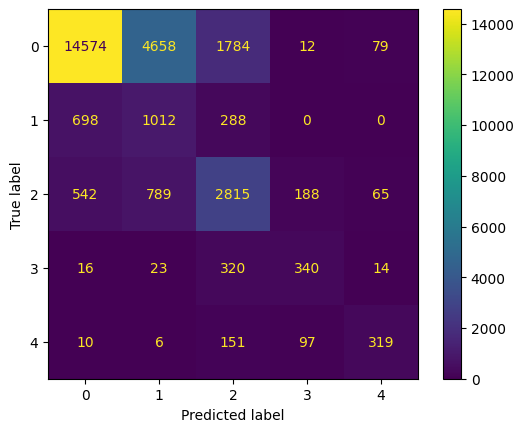

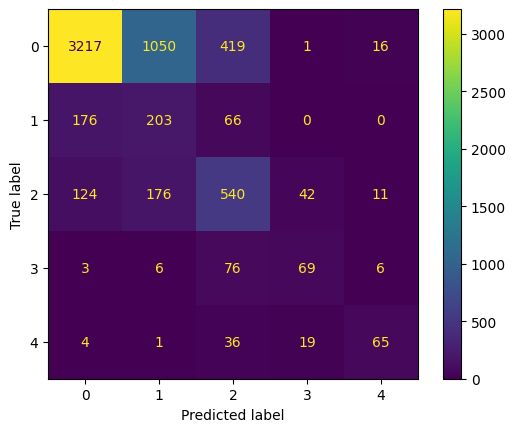

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
conf_matr_train = confusion_matrix(labels_train, preds_train_)
disp_train = ConfusionMatrixDisplay(conf_matr_train)
disp_train.plot()
plt.show()

conf_matr_val = confusion_matrix(labels_val,preds_val_)
disp_val = ConfusionMatrixDisplay(conf_matr_val)
disp_val.plot()
plt.show()

# Grad-Cam

In [ ]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
def make_gradcam_heatmap(img, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.get_layer('model').inputs, [model.get_layer('model').get_layer(last_conv_layer_name).output, model.get_layer('model').output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap + img * alpha
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path,width=400))

1/1 [==============================] - 0s 25ms/step
Predicted: 3


<ipython-input-21-70936e60b6cb>:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


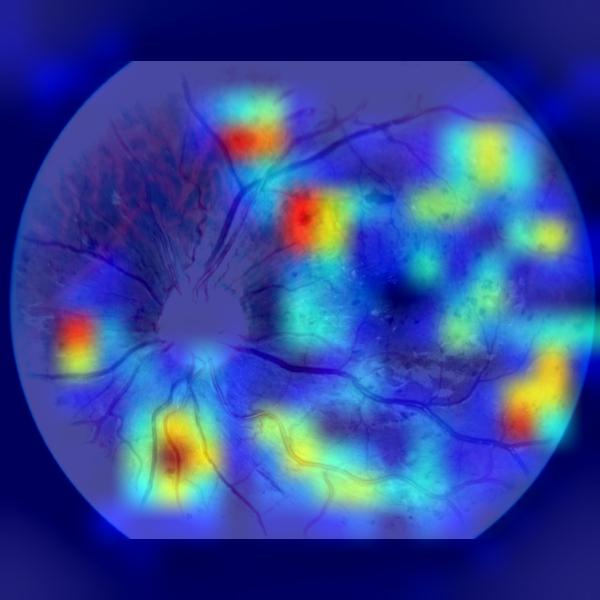

In [ ]:
loaded_model = model
last_conv_layer_name = 'conv5_block3_out'
a = np.array(x[7]) #la img a probar

# Remove last layer's softmax
loaded_model.layers[-1].activation = None

# Print what the top predicted class is
img = np.expand_dims(a, axis=0)
preds = loaded_model.predict(img)
pred = np.argmax(preds)
print("Predicted:", pred)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img, loaded_model, last_conv_layer_name)

# Display
save_and_display_gradcam(a, heatmap)

# Generar Submission

In [ ]:
path = "/content/drive/MyDrive/Proyecto-2/Modelos/paraSubir-Santi20230704-170522"
model = tf.keras.models.load_model(path)

In [ ]:
%cd /content/
!unzip -qq '/content/drive/MyDrive/Proyecto-2/retinopatia_test.zip'

test_folder = '/content/drive/MyDrive/Proyecto-2/retinopatia_test/test'
os.listdir(test_folder)[0:3]

# Definir las características
img_size = [640, 1024]
batch_size = 8
buffer_size = 8
prefetch = tf.data.AUTOTUNE

# Ruta de la carpeta de pruebas
image_paths = [test_folder + item for item in os.listdir(test_folder)]

# Obtener la lista de rutas de las imágenes en la carpeta de pruebas
# image_paths = tf.io.gfile.glob(test_folder + "/*.jpeg")  # Cambia la extensión si tus imágenes tienen una diferente

# Crear un conjunto de datos a partir de las rutas de las imágenes
test_dataset = tf.data.Dataset.from_tensor_slices(image_paths)

# Cargar las imágenes
def load_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    return img

test_dataset = test_dataset.map(load_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)

/content
replace test/10000_left.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
def scaleRadius(img, scale = 300):
  x = tf.math.reduce_sum(tf.cast(img[int(tf.shape(img)[0]/2), :, :], tf.float32), axis=1)
  r = tf.math.reduce_sum(tf.cast((x>tf.math.reduce_mean(x)/10), tf.float32))/2
  if (r<50):
    r=tf.constant(50.)
  s = scale * 1.0/ r
  shape = tf.cast(tf.shape(img),tf.float32)
  img_pre = tf.image.resize(img, (shape[0]*s, shape[1]*s))
  if (s<tf.constant(1.0)):
    img_pre = tf.image.pad_to_bounding_box(img_pre,( tf.constant(640) - tf.shape(img_pre)[0])//2, tf.constant(0) ,tf.constant(640), tf.shape(img_pre)[1])
  img_pre = img_pre[tf.shape(img_pre)[0]//2 - tf.constant(scale):tf.shape(img_pre)[0]//2 + tf.constant(scale), tf.shape(img_pre)[1]//2 - tf.constant(scale):tf.shape(img_pre)[1]//2 + tf.constant(scale), :]
  img_pre = tf.cast(img_pre,tf.uint8)

  return img_pre


def preprocess(img, scale = 300):
  img = tf.cast(tf.image.resize_with_pad(img,640,1024),tf.uint8)
  img_pre = scaleRadius(img)
  return img_pre


X_test = test_dataset.map(preprocess).batch(32)

probas = model.predict(X_test)
pred = np.argmax(probas,axis=1)

test_name = os.listdir(test_folder)
data = {'image': test_name,
        'level': pred}

submission = pd.DataFrame(data)
submission["image"] = [valor.replace('.jpeg', '') for valor in submission["image"]]


submission.to_csv('submision_santi.csv')

 347/1675 [=====>........................] - ETA: 17:50